# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [2]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('/Users/amirzoyeva/Desktop/матрички/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [3]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [4]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше).
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Для начала выведите необходимые формулы аналитически, а затем реализуйте их в коде. Ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.  Везде считайте $r < m, n$.

$\|A - UV^\top\|_F^2  = \mathrm{Tr}((A-UV^\top)^\top((A-UV^\top)) = \mathrm{Tr}((A^\top-VU^\top)((A-UV^\top)) = \mathrm{Tr}(A^\top A - A^\top U V^\top - VU^\top A + VU^\top UV^\top) = \mathrm{Tr}(A^\top A) - \mathrm{Tr}( A^\top U V^\top) -  \mathrm{Tr}(VU^TA) + \mathrm{Tr}(VU^\top U V^\top) \overset{\text{по свойствам следа}}{=} \|A\|_F^2  -  \mathrm{Tr}(V^\top A^\top U) - \mathrm{Tr}((VU^\top A)^\top) + \mathrm{Tr}((V^\top V)(U^\top U)) = \|A\|_F^2  -  2\mathrm{Tr}((V^\top A^\top) U) + \mathrm{Tr}((V^\top V)(U^\top U))$


Сложность:


$(V^\top V) - O(nr^2)$

$(U^\top U) - O(mr^2)$

$V^\top A^\top$ - умножение на матрицу $A^\top$

$V^\top A^\top U - O(mr^2)$


In [5]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """


    ans = A_norm**2 - 2*np.trace((VT@A.T)@U) + np.trace((VT@VT.T)@(U.T@U))
    ans = np.sqrt(ans)
    return ans

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

По формуле для нахождения ортопроектора на подпространство $P(U_1) = U_1 U_1^\top, P(U_2) = U_2 U_2^\top$


Получаем
$\|(I - U_1 U_1^\top)U_2 U_2^\top \|_2 $

Обозначим $ (I - U_1 U_1^\top)U_2$ за A

Знаем, что $\|B \|_2 = \|B^\top\|_2 \forall B \in \mathbb{R}^{m \times r}$, так как транспонирование не влияет на старшее сингулярное число

$\|   A U_2^\top \|_2 =\|   U_2 A^\top \|_2 = \mathrm{sup} \frac{\| U_2 A^\top x\|_2 }{\| x\|_2} = \mathrm{sup}\frac{\sqrt{(U_2 A^\top x)^\top (U_2 A^\top x)}}{\| x\|_2} = 
\mathrm{sup}\frac{\sqrt{x^\top A U_2^\top (U_2 A^\top x)}}{\| x\|_2} = 
\mathrm{sup}\frac{\sqrt{x^\top A  A^\top x}}{\| x\|_2} = \mathrm{sup}\frac{\|A^\top x\|_2}{\| x\|_2}=\| A^\top \|_2 =  \|A\|_2$
Значит, можем откинуть $U_2^\top$ под нормой
Получим:
$\|(I - U_1 U_1^\top)U_2 \|_2 = \|(U_2 - U_1 (U_1^\top U_2)) \|_2 $

Сложность умножений:

$(U_1^\top U_2) - O(mr^2)$

$ U_1 (U_1^\top U_2)) - O (mr^2)$

Следовательно, алгоритм имеет сложность $O (mr^2)$


  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [6]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
    """
    dist = np.linalg.norm(U2 - U1@(U1.T@U2), 2)
    return dist

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию.

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [7]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration

        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    fs = []
    deltas = []
    dists = []
    norm_A = sparse_norm(A)
    m = np.shape(A)[0]
    n = np.shape(A)[1]
    Ucur = np.linalg.qr(np.random.randn(m, rank))[0]
    Vcur = np.random.randn(n, rank)
    Vcur = np.linalg.qr(Vcur)[0]
    Uprev = None

    fs.append(als_functional(A, norm_A, Ucur, Vcur.T))
    delt = 1e9
    dists.append(1)
    
    iter = 0
    while delt > tolerance:
        iter += 1
        Uprev = Ucur
        Ucur = np.linalg.qr(A @ Vcur)[0]
        Vcur1 = A.T @ Ucur
        fs.append(als_functional(A, norm_A, Ucur, Vcur1.T))
        Vcur = np.linalg.qr(Vcur1)[0]
        dists.append(dist_between_subspaces(Uprev, Ucur))
        delt = fs[-2] - fs[-1]
        deltas.append(delt)
        
        if debug:
            print(f"Iter:{iter}, fs: {fs[-1]}, delta_cur: {delt},  dist {dists[-1]}")
    
    return Ucur, Vcur1.T, fs, deltas, dists




Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

Iter:1, fs: 1802.302754564547, delta_cur: 201.92461553291946,  dist 0.999999909643895
Iter:2, fs: 1662.3801328460438, delta_cur: 139.92262171850325,  dist 0.8658210576827607
Iter:3, fs: 1647.6824608455688, delta_cur: 14.697672000474995,  dist 0.5201462795012504
Iter:4, fs: 1643.2899242406775, delta_cur: 4.3925366048913475,  dist 0.35441146994308187
Iter:5, fs: 1641.5768471422425, delta_cur: 1.713077098434951,  dist 0.23733191242834006
Iter:6, fs: 1640.7497832537108, delta_cur: 0.8270638885317112,  dist 0.18036709473715437
Iter:7, fs: 1640.276162681622, delta_cur: 0.4736205720887483,  dist 0.1465463249911353
Iter:8, fs: 1639.9730460708902, delta_cur: 0.3031166107318768,  dist 0.1251272572827063
Iter:9, fs: 1639.7649067694017, delta_cur: 0.20813930148847248,  dist 0.10960473260947662
Iter:10, fs: 1639.615033195728, delta_cur: 0.14987357367363074,  dist 0.0975111642375842
Iter:11, fs: 1639.5033194190703, delta_cur: 0.11171377665777982,  dist 0.08765800532885623
Iter:12, fs: 1639.417798550

[]

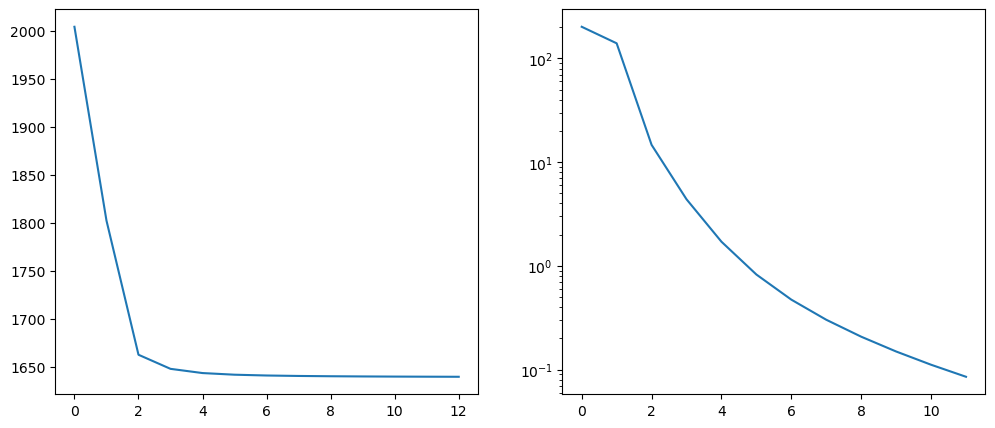

In [8]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy()

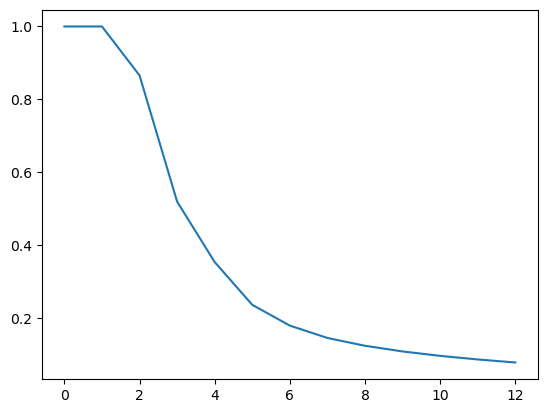

In [9]:
# опционально

plt.plot(dists)

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [10]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)

Uals, VTals, fs, deltas, dists = ALS(A_train, rank = 30)
funct_als = als_functional(A_train, A_norm, Uals, VTals)

Urand, Srand, VTrand = randomized_svd(A_train, n_components = 30)
funct_rand = als_functional(A_train, A_norm, Urand, np.diag(Srand) @ VTrand)

Usvd, Ssvd, VTsvd = svds(A_train, k = 30)
funct_svd = als_functional(A_train, A_norm, Usvd, np.diag(Ssvd) @VTsvd)

print(f'Functional ALS: {funct_als}')
print(f'Functional Rand SVD: {funct_rand}')
print(f'Functional Sparse SVD: {funct_svd}')


/Users/amirzoyeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


Functional ALS: 1638.9638612397787
Functional Rand SVD: 1638.9896893067187
Functional Sparse SVD: 1638.9008364308481


### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

In [11]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array

        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    proec = (V @ (V.T @ score_mat.T)).T
    rating = np.argsort(-proec, axis=1)[:, :pred_am]
    return rating

    
    

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [12]:
from scipy.sparse import find


def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user, :])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:, -1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [13]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs

    """
    
    hit_rates = []
    hit_idx = evaluate_model(A_test, max(pred_ams), V)
     
    for top in pred_ams:
        hits = sum(i < top for i in hit_idx)
        hit_rate = hits / len(hit_idx)
        hit_rates.append(hit_rate)

    return hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [15]:
Usvd, Ssvd, VTsvd = svds(A_test[:1000,:], k = 30)
hit_rates = get_hit_rates(A_test[:1000,:], [10], VTsvd.T)
print(hit_rates[0]*100)


12.127440904419322


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

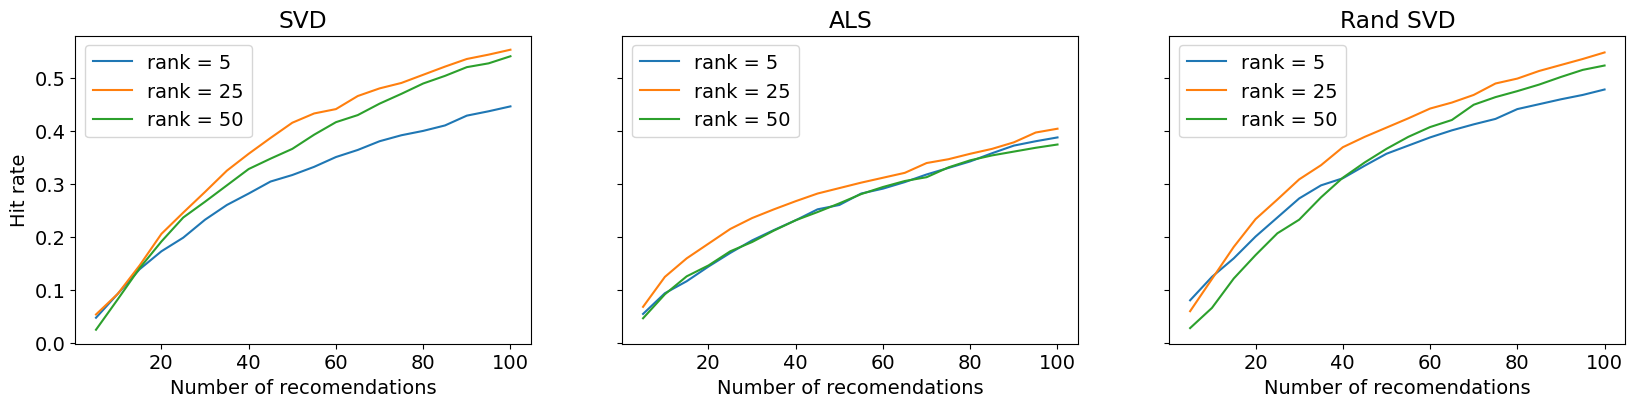

In [18]:
from scipy.sparse.linalg import svds

pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, VT.T)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

**YOUR WORDS GO HERE**

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Ранг 25 получился оптимальным для всех трех алгоритмов


## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

In [ ]:
def tuck2full(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            A: d-dimensional numpy array of the size (n1, n2, ..., nd)
    """
    # TO BE FILLED
    raise NotImplementedError()

2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [ ]:
def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)
    """
    # TO BE FILLED
    raise NotImplementedError()

3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [ ]:
# TO BE FILLED

4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

**YOUR WORDS GO HERE**

5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

In [ ]:
def tuck_norm(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            norm: Frobenius norm of A = [G; U1 ... Ud]
    """
    # TO BE FILLED
    raise NotImplementedError()